# **Resume Classification with VGG19**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [58]:
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50, VGG19
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

# **Resizing & Data Augmentation**

In [3]:
def resize_images(input_folder, output_folder, target_size=(600, 800)):

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate through each image in the input folder
    for filename in os.listdir(input_folder):
        img_path = os.path.join(input_folder, filename)

        img = Image.open(img_path)

        # Resize the image to the target size
        img_resized = img.resize(target_size, Image.ANTIALIAS)

        # Save the resized image to the output folder
        output_path = os.path.join(output_folder, filename)
        img_resized.save(output_path)


In [4]:
def augment_images(input_folder, output_folder, augment_size=10):
    # Set up data augmentation
    datagen = ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        fill_mode='nearest'
    )

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate through each image in the input folder
    for filename in os.listdir(input_folder):
        img_path = os.path.join(input_folder, filename)

        img = Image.open(img_path)

        # Convert the image to a NumPy array and resize
        img_array = np.array(img.resize((600, 800)).convert("RGB"))

        img_array = img_array.reshape((1,) + img_array.shape)

        # Apply data augmentation
        i = 0
        for batch in datagen.flow(img_array, batch_size=1, save_to_dir=output_folder, save_prefix='augmented', save_format='png'):
            i += 1
            if i >= augment_size:
                break  # Break after generating the specified number of augmented images

In [5]:
# Resizing non-resume images
resize_images('/content/drive/MyDrive/Bureau_assignment/Dataset/Non-resume', '/content/drive/MyDrive/Bureau_assignment/Dataset/non-res_resized')

<ipython-input-3-f2626d97deb4>:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img_resized = img.resize(target_size, Image.ANTIALIAS)


In [16]:
# Augmenting non resume resized images
augment_images('/content/drive/MyDrive/Bureau_assignment/Dataset/non-res_resized', '/content/drive/MyDrive/Bureau_assignment/Dataset/augmented_non-res', augment_size=10)

In [17]:
# Resizing resume images
resize_images('/content/drive/MyDrive/Bureau_assignment/Dataset/Resume', '/content/drive/MyDrive/Bureau_assignment/Dataset/res_resized')

<ipython-input-3-f2626d97deb4>:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img_resized = img.resize(target_size, Image.ANTIALIAS)


In [20]:
# Augmenting non resume resized images
augment_images('/content/drive/MyDrive/Bureau_assignment/Dataset/res_resized', '/content/drive/MyDrive/Bureau_assignment/Dataset/augmented_res', augment_size=10)

# **Training the Model**

In [59]:
train_data_dir = '/content/drive/MyDrive/Bureau_assignment/Dataset/Augmented_dataset'

# Define image size and batch size
img_size = (600, 800)
batch_size = 32

# Set up data generators for training
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',  # As it is a binary classification task
    shuffle=True  # For training we can shuffle the images
)


# Loading VGG19 model with pre-trained weights (excluding top layers)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(600, 800, 3))

# Then we freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# We can add some extra classification layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
predictions = layers.Dense(1, activation='sigmoid')(x)

# final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
training = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10
)


Found 2647 images belonging to 2 classes.
80134624/80134624 [==============================] - 0s 0us/step


Epoch 1/10
82/82 [==============================] - 261s 2s/step - loss: 0.5032 - accuracy: 0.7637
Epoch 2/10
82/82 [==============================] - 136s 2s/step - loss: 0.3268 - accuracy: 0.8654
Epoch 3/10
82/82 [==============================] - 136s 2s/step - loss: 0.2443 - accuracy: 0.9098
Epoch 4/10
82/82 [==============================] - 136s 2s/step - loss: 0.1985 - accuracy: 0.9312
Epoch 5/10
82/82 [==============================] - 137s 2s/step - loss: 0.1623 - accuracy: 0.9465
Epoch 6/10
82/82 [==============================] - 136s 2s/step - loss: 0.1320 - accuracy: 0.9579
Epoch 7/10
82/82 [==============================] - 136s 2s/step - loss: 0.1220 - accuracy: 0.9602
Epoch 8/10
82/82 [==============================] - 136s 2s/step - loss: 0.1064 - accuracy: 0.9656
Epoch 9/10
82/82 [==============================] - 136s 2s/step - loss: 0.0932 - accuracy: 0.9706
Epoch 10/10
82/82 [==============================] - 136s 2s/step - loss: 0.0900 - accuracy: 0.9713


In [60]:
# Save the trained model
model.save('vgg19_resume_classifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [61]:
model.layers

In [46]:
# For loading the saved model

from tensorflow.keras.models import load_model

# model = load_model('/content/vgg19_resume_classifier_new.h5')

# **Predictions & Test Accuracy**

In [62]:
# Function to preprocess the image for prediction
def preprocess_image(img_path, target_size=(600, 800)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array / 255.0  # Normalize the pixel values to the range [0, 1]

# prediction on a single image
test_image_path = '/content/drive/MyDrive/Bureau_assignment/Dataset/Resume/Screenshot 2023-12-30 163245.png'  # Replace with the path to the test image
preprocessed_image = preprocess_image(test_image_path)

# prediction
prediction = model.predict(preprocessed_image)

if prediction > 0.5:
    print("Prediction: Resume")
else:
    print("Prediction: Non-Resume")

1/1 [==============================] - 4s 4s/step
Prediction: Resume


In [63]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Bureau_assignment/Dataset/Test_dataset',
    target_size=(600, 800),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # For testing there's no need to Shuffle the images
)

evaluation = model.evaluate(test_generator)
print(f'Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}')

Found 83 images belonging to 2 classes.
3/3 [==============================] - 51s 24s/step - loss: 0.3636 - accuracy: 0.7952
Test Loss: 0.36357375979423523, Test Accuracy: 0.7951807379722595


(83, 1)

# **Confusion Matrix**

3/3 [==============================] - 4s 2s/step


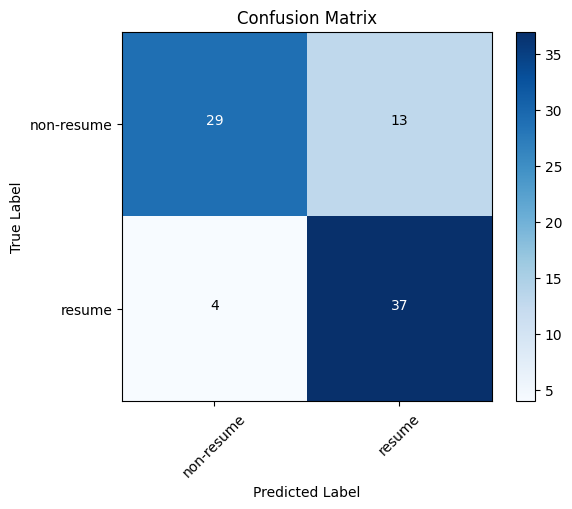

In [91]:
from sklearn.metrics import confusion_matrix, classification_report

# predictions
y_pred = model.predict(test_generator)

# we convert probabilities to class labels by rounding
y_pred_labels = np.round(y_pred).squeeze()

# true labels
y_true = test_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)

# Ploting confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Adding labels
classes = test_generator.class_indices.keys()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# values in each cell
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# **Evaluation of Model**

In [92]:
# Then we import metrics

from sklearn.metrics import precision_score, recall_score, f1_score

In [94]:
precision = precision_score(y_true, y_pred_labels)
recall = recall_score(y_true, y_pred_labels)
f1 = f1_score(y_true, y_pred_labels)

In [97]:
print("Accuracy:", evaluation[1])
print("Precision:", precision)
print("Recall:", recall)
print("F1_score:", f1)

Accuracy: 0.7951807379722595
Precision: 0.74
Recall: 0.9024390243902439
F1_score: 0.8131868131868132
